<a href="https://colab.research.google.com/github/rafaelweinert/DD1420_ML_Excercises/blob/main/DD1420HT23_Ex4_STUDENT_VERSION_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from typing import List
from types import SimpleNamespace
from tqdm import tqdm

# Exercise 4 - ML & Neural Networks  (DD1420 HT23)

## Instructions

This Jupyter Notebook contains the exercises for DD1420 **Module 4 ML & Neural Networks**. There are a several problems in this exercise, each broken into numbered subproblems, *e.g.* 1.1.1. The points for each problem are marked *e.g.* $\color{red}{\text{(} x \text{ points)}}$. In total, the exercise is worth **12** points.

<br>

Students are allowed to work on this exercise in pairs. Make sure you have formed a group in Canvas with your partner. Each student is responsible for following the Code of Conduct. In particular (1) All members of a group are responsible for the group's work, (2) Every student shall honestly disclose any help received and sources used, and (3) Do not copy from other people's solutions. If you need assistance with the exercise, you are encouraged to post a question to the appropriate Discussion Topic or sign up for a help session.

<br>

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and delete `raise NotImplementedError()` once you have implemented the solution.

<br>

You should not import any libraries on top of the ones included in the assignment. Derivation questions can be answered using $\LaTeX$, or you may upload an image of your derivation. To do so in *Google Colab* simply create a text cell, click on the `insert image` icon, and upload an image to the notebook as we have demonstrated below.

<br>

**Submission** - once you have completed the exercise make sure everything runs as expected by going into `Runtime` -> `Restart and Run all`. Then download the notebook by clicking `file` -> `download` -> `download .ipynb`. Then **rename the file to include your name** (and **your partner's name** if you have one) as follows

<br>

`Ex??_LASTNAME_FIRSTNAME_and_LASTNAME_FIRSTNAME.ipynb`

<br>

where you replace `??` with the correct exercise number. If you are working alone you do not need to include a partner name.

<br>

Good luck!

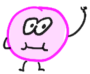

#Name
**Fill in your name and your partner's name below** (and name the `.ipynb` file correctly):

<br>

### Katharina Deckenbach

### Rafael Weinert

# 4.1 Training a neural network with backpropagation  (12 points)

In this exercise we will once again train a machine learning algorithm to classify handwritten digits from MNISt, although this time we will use a bigger version with $64 \times 64$ images and 60,000 examples.

<br>

We will make use of [PyTorch](https://pytorch.org/) which is a popular machine learning framework for developing neural networks. You will not be expected to write PyTorch-specific code in this exercise, just standard numpy and Python. You won't need to follow along with what PyTorch is doing - we try to explain the important bits.

<br>

The first thing we will do is load the MNIST handwritten digits dataset,

In [2]:
# these are pytorch's dataset class. it downloads and sets up the dataset
mnist_train = torchvision.datasets.MNIST(root="data",
                                         train=True,
                                         download=True,
                                         transform=T.Compose([T.ToTensor(),
                                                              T.Lambda(lambda x: torch.flatten(x)),
                                                              ]),
                                         )
mnist_test = torchvision.datasets.MNIST(root="data",
                                        train=False,
                                        download=True,
                                        transform=T.Compose([T.ToTensor(),
                                                             T.Lambda(lambda x: torch.flatten(x)),
                                                             ]),
                                        )

We use something called a `dataloader` class from PyTorch, which handles feeding data from the dataset to the network. It does things like shuffle the data and yield samples.



In [3]:
# these are pytorch's dataloader class. they shuffle and yield sample points
# for us. you don't have to code data manipulations yourself in this exercise
train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
val_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

Next we will define the size of our neural network, which will have $L = 3$ layers of width $m_{\ell=\{1,\dots,L\}} = \{784, 30, 10\}$

In [4]:
# hyperparameters. sets up the network dimensions
# how many nodes in each
layers_list = [784, 30, 10]
L = len(layers_list)

We will define a function that will rescale our random weights to a distribution that has been proven to be a better initialization than just a standard `randn` distribution. The Xavier initialization simply divides the randomly initialized weights of each layer by the square root of the input size $\sqrt{k}$.

In [5]:
def initialization_scaling(weight_matrix):
  """
  This implements Xavier initialization. It helps training of deep networks.
  """
  input_size = weight_matrix.shape[0]
  return weight_matrix / math.sqrt(input_size)

**4.1.1** *Complete the function provided below that creates a single layer of a neural network. Given the input size and the ouptut size this function should create the weight matrix and bias vector with random initialization. If the `scaled_init` flag is `True` it should apply the Xavier scaled defined above. The bias vector should be initialized to zero.* $\color{red}{\text{(1 point)}}$

In [6]:
def create_single_layer(input_size: int, output_size: int, scaled_init=False):
  """
  Create a single layer
  output: a layer object. weights and biases are in layer.weight and layer.bias

  Usage:
    layer = create_single_layer(784, 10)
    layer_weight_matrix = layer.weight
    layer_bias_vector = layer.bias
  """
  bias_vector = np.random.randn(output_size)
  weight_matrix = np.random.randn(output_size, input_size)
  if scaled_init:
    weight_matrix = initialization_scaling(weight_matrix)
    bias_vector = np.zeros((output_size,1))

  # The output being a SimpleNamespace is just a coding convenience. It
  # emulates how we access the weights and biases in pytorch.
  # without this we would have to access weights using layers[0][0],
  # with this we can do layers[0].weight so that it is a bit more readable
  return SimpleNamespace(weight=weight_matrix, bias=bias_vector)

**4.1.2** *Complete the function provided below that creates all the layers of the neural network using the function you created in 4.1.1. The `layers_list` contains a list of layer widths for each layer. Loop through that list, create each layer, and append it to a `layers` list. The function should output `layers`, a list of initialized layers.* $\color{red}{\text{(1 point)}}$

In [7]:
def create_layers(layers_list: List):
  """
  Creates the weights and biases if layers according to the given list
  output: a list of layers

  Usage:
    layers = create_layers(layers_list)
    some_layer = layers[np.random.randint(L)]
  """

  #To match the Lecture notation we start with idx=1, i.e. there is no W^(0) or b^(0)
  layers = [None]
  for idx in range(L-1):
      layer = create_single_layer(layers_list[idx],layers_list[idx+1],True)
      layers.append(layer)
  return layers

In [8]:
print(layers_list)

[784, 30, 10]


Next, we provide you with code for the logistic sigmoid activation function `sigmoid` and its derivative `sigmoid_prime` which should be applied to pre-activations.

In [9]:
def sigmoid(z):
  """
  The sigmoid function
  Usage:
    activation_output = sigmoid(some_input)
  """
  return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
  """
  $\sigma\prime$ in the lecture notes
  """
  return sigmoid(z)*(1-sigmoid(z))

**4.1.3** *Complete the following functions that the define the MSE loss (the loss for a single sample $\ell_{MSE}$) and its derivative.* $\color{red}{\text{(1 point)}}$

Note that this is not a very good choice of a loss for classification, but the derivative is easier to calculate and code and it will give reasonable results on MNIST.

In [10]:
def loss_fn(y_hat, y):
  """
  This is the MSE loss for a single sample.
  """
  return np.square(y - y_hat)


def dloss_dyhat(y_hat, y):
  """
  Gradient of the MSE loss for a single sample.
  """
  #result = np.full((1,y.shape[0]), np.mean((-(2 * (y - y_hat)))))
  return (-(2 * (y - y_hat))).T
  #return result


Next, we will start to define some of the essential functions for training the neural network. We will start with a function for the pre-activations $z^{(\ell)}$ and the activations $a^{(\ell)}$.

**4.1.4**.  *Complete the function below that returns the preactivation given the layers weight matrix $W^{(\ell)}$, bias vector $b^{(\ell)}$ and the previous layers activation $a^{(\ell-1)}$.* $\color{red}{\text{(1 point)}}$

hint: [The @ operator can be used as a shorthand for np.matmul on ndarrays.](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html)

In [11]:
def calculate_preactivation(layer_weight, layer_bias, previous_activation):
  #print(layer_weight.shape)
  #print(layer_bias.shape)
  #print(previous_activation.shape)
  z = layer_weight @ previous_activation + layer_bias

  return z

A quick sanity check.

In [12]:
W = np.array([[2,-2], [-3,-1], [1, -3]])
b = np.array([[-1], [0], [0]])
a = np.array([[2],[-2]])
calculate_preactivation(W,b,a)

array([[ 7],
       [-4],
       [ 8]])

**4.1.5**.  *Complete the function below that returns the activation of a layer given the preactivation $z^{(\ell)}$.* $\color{red}{\text{(1 point)}}$

In [13]:
def calculate_activation(z):
  return sigmoid(z)

A quick sanity check.

In [14]:
z = np.array([[-1], [0], [1]])
calculate_activation(z)

array([[0.26894142],
       [0.5       ],
       [0.73105858]])

**4.1.6.** *Write a function that computes and returns the gradient of the last layer $g^{(L)}$. You should make use of some previous functions you have written. You may need to use `.squeeze()` to ensure dimensions match.* $\color{red}{\text{(1 point)}}$

In [15]:
def calculate_g_L(y, a, z):
  dy_hat = dloss_dyhat(a, y)
  return dy_hat @ np.diag(sigmoid_prime(z).squeeze())

A quick sanity check.


In [16]:
y = np.ones((5,1))
a = np.zeros((5,1))
z = np.ones((5,1))
calculate_g_L(y,a,z)


ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

**4.1.7.** *Write a function that computes and returns the gradient of an aribtrary layer $g^{(\ell)}$ (except $L$). You may need to use `.squeeze()` to ensure dimensions match.* $\color{red}{\text{(1 point)}}$

In [ ]:
def calculate_g_l(g_l_previous, layer_weight_previous, z):
  g_l = g_l_previous @ layer_weight_previous @ np.diag(sigmoid_prime(z).squeeze())
  return g_l

A quick sanity check.


In [ ]:
y = np.ones((5,1))
a = np.zeros((5,1))
z = np.ones((5,1))
g_L = calculate_g_L(y,a,z)
W = np.ones((5,5))
z = np.ones((5,1))
g_l = calculate_g_l(g_L,W,z)
g_l

array([[-0.38656252, -0.38656252, -0.38656252, -0.38656252, -0.38656252]])

In [ ]:
g_L

array([[-0.39322387, -0.39322387, -0.39322387, -0.39322387, -0.39322387]])

**4.1.8.** *Write a function that computes and returns the gradient of the loss w.r.t. the weights $\nabla_{W^{(\ell)}} J$ given the gradient $g^{(\ell)}$ and the activations from the next layer $a^{(\ell-1)}$.* $\color{red}{\text{(1 point)}}$

In [ ]:
def calculate_nabla_weight(g_l, a_next):
  return g_l.T @ a_next.T

A quick sanity check.

In [ ]:
g_l = np.ones((1,5))
a_next = np.ones((3,1))
nabW = calculate_nabla_weight(g_l, a_next)
nabW

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

**4.1.9.** *Write a function that computes and returns the gradient of the loss w.r.t. the bias $\nabla_{b^{(\ell)}} J$ given the gradient $g^{(\ell)}$ and the activations from the next layer $a^{(\ell-1)}$.* $\color{red}{\text{(1 point)}}$

In [ ]:
def calculate_nabla_bias(g_l):
  return g_l.T

A quick sanity check

In [ ]:
g_l = np.ones((1,5))
nabb = calculate_nabla_bias(g_l)
nabb

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

Great! We are finally ready to put everything together and train the neural network. We have provided most of the code for you.

<br>

**4.1.10.** *Insert the functions you have defined in **4.1.2** and **4.1.5** through **4.1.9** in the correct places in the following code. Then run the code to train the neural network to classify handwritten digits.* $\color{red}{\text{(3 points)}}$

In [ ]:
for l in range(L-1, 0, -1):
    print(l)

2
1


In [ ]:
# initialization = create the layers
layers = create_layers(layers_list)
lr = 3.0
# this is one epoch
# ====== loop through 1 epoch using the data loader =====

for (x, y) in tqdm(train_loader, desc=f'Epoch progress'):
  # we used pytorch loaders, convert back to numpy and proper shape
  x = x.numpy().T
  # our network uses one_hot encoding to classify the digit so
  # we convert the target to a one_hot encoding
  y = torch.nn.functional.one_hot(y,num_classes=10).numpy().T
  # actual updates occur here
  activation = x
  # set up the variables for saving the a & z values
  # a^(0) is set to x
  activations = [activation]
  # z^(0) does not exist so we store a None for it
  pre_activations = [None]

  # ====== do forward propagation =====
  # looping through the layers, computing and storing activations & pre-activations
  for layer in layers[1:]: #since layers[0] does not exist/is None
    print(layer)
    print(len(activations))
    pre_activation = calculate_preactivation(layer.weight, layer.bias, activations[-1])
    activation = sigmoid(pre_activation)
    # store these for the backprop
    pre_activations.append(pre_activation)
    activations.append(activation)
    #print('activation', activation)

  # ===== do backpropagation =====
  # setting up record keeping of the gradients, nabla_weights and nabla_biases
  # note that we have no gradients for W^(0) since we index starting at 1
  g_ls = [None]
  nabla_weights = [None]
  nabla_biases = [None]
  g_ls.extend([np.zeros((1, m)) for m in layers_list] )
  nabla_weights.extend([np.zeros_like(layer.weight) for layer in layers[1:]])
  nabla_biases.extend([np.zeros_like(layer.bias) for layer in layers[1:]])

  # looping through the layers, compute gradients and nabla's
  for l in range(L-1, 0, -1):
    
    # g^L is calculated differently, so we check and handle that first
    if l == L-1:
      g_ls[l] = calculate_g_L(y,activations[l],pre_activations[l])
    else:
      g_ls[l] = calculate_g_l(g_ls[l+1], nabla_weights[l+1], pre_activations[l])
    nabla_weights[l] = calculate_nabla_weight(g_ls[l], activations[l-1])
    nabla_biases[l] = calculate_nabla_bias(g_ls[l])
  # update the weights with the lr according to SGD algorithm
  for l in range(L-1, 0, -1):
    #if l == 1:
      #print(layers[l].weight)
      #print(nabla_weights[l][0][0])
    layers[l].weight = layers[l].weight - lr * nabla_weights[l]
    layers[l].bias = layers[l].bias - lr * nabla_biases[l]

    #if l == 1:
      #print(layers[l].weight)


Epoch progress:   0%|          | 13/60000 [00:00<08:02, 124.41it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],


Epoch progress:   0%|          | 42/60000 [00:00<07:28, 133.71it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14425148],
       [-0.09965328],
       [-0.2426382 ],
       [-0.06788963],
       [-0.12990308],
       [-0.14235548],
       [-0.24095119],
       [-0.17127684],
       [-0.0663172 ],
       [-0.2061759 ],
       [-0.12114773],
       [-0.24985949],
       [-0.06500721],
       [-0.24809908],
       [-0.22556745],
       [-0.18996034],
       [-

Epoch progress:   0%|          | 70/60000 [00:00<07:27, 134.07it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14472809],
       [-0.11198832],
       [-0.2426404 ],
       [-0.08048849],
       [-0.14328465],
       [-0.14247881],
       [-0.2409521 ],
       [-0.17150809],
       [-0.07272649],
       [-0.20620077],
       [-0.14060074],
       [-0.24987806],
       [-0.06720816],
       [-0.24812143],
       [-0.22559078],
       [-0.18999915],
       [-0.1

Epoch progress:   0%|          | 98/60000 [00:00<07:47, 128.05it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14527092],
       [-0.12783529],
       [-0.24265739],
       [-0.0837368 ],
       [-0.14789489],
       [-0.14588754],
       [-0.24095238],
       [-0.1716399 ],
       [-0.08357867],
       [-0.20620516],
       [-0.14469761],
       [-0.24987938],
       [-0.07417043],
       [-0.24812252],
       [-0.22561071],
       [-0.19000886],
       [-0.1

Epoch progress:   0%|          | 111/60000 [00:00<08:51, 112.74it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14695555],
       [-0.12955384],
       [-0.24265921],
       [-0.08747868],
       [-0.14915163],
       [-0.14590757],
       [-0.24095253],
       [-0.17219584],
       [-0.08506847],
       [-0.2062333 ],
       [-0.14790725],
       [-0.24988095],
       [-0.07498645],
       [-0.2481258 ],
       [-0.22565128],
       [-0.19046602],
       [-0.1

Epoch progress:   0%|          | 140/60000 [00:01<07:49, 127.43it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14704371],
       [-0.13261154],
       [-0.24266064],
       [-0.08941968],
       [-0.15287653],
       [-0.14786384],
       [-0.2409634 ],
       [-0.17431021],
       [-0.08599046],
       [-0.20623965],
       [-0.14833775],
       [-0.24989406],
       [-0.07563318],
       [-0.24814854],
       [-0.22565266],
       [-0.19049466],
       [-

Epoch progress:   0%|          | 173/60000 [00:01<06:56, 143.73it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.1475347 ],
       [-0.14015952],
       [-0.24268743],
       [-0.09673118],
       [-0.1623906 ],
       [-0.14837044],
       [-0.24097358],
       [-0.17680979],
       [-0.09126281],
       [-0.20633737],
       [-0.15447163],
       [-0.24990861],
       [-0.07770721],
       [-0.24832132],
       [-0.22575468],
       [-0.19085272],
       [-

Epoch progress:   0%|          | 188/60000 [00:01<07:12, 138.32it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14808802],
       [-0.1421116 ],
       [-0.2427074 ],
       [-0.10057577],
       [-0.16743739],
       [-0.15037289],
       [-0.24098013],
       [-0.17958372],
       [-0.09915839],
       [-0.20637825],
       [-0.15661857],
       [-0.24991703],
       [-0.07916924],
       [-0.24833798],
       [-0.22696231],
       [-0.19103681],
       [-

Epoch progress:   0%|          | 222/60000 [00:01<07:36, 131.01it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.148366  ],
       [-0.14548873],
       [-0.2427937 ],
       [-0.1071175 ],
       [-0.17201327],
       [-0.15043351],
       [-0.24098155],
       [-0.18082739],
       [-0.10080012],
       [-0.20641514],
       [-0.15788592],
       [-0.24997281],
       [-0.08036722],
       [-0.2483407 ],
       [-0.22706166],
       [-0.19121531],
       [-0.1

Epoch progress:   0%|          | 236/60000 [00:01<07:44, 128.79it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.14884325],
       [-0.14971932],
       [-0.24284515],
       [-0.10842774],
       [-0.17393469],
       [-0.15461906],
       [-0.24098482],
       [-0.18266197],
       [-0.10207953],
       [-0.20657531],
       [-0.16232683],
       [-0.24998539],
       [-0.08530013],
       [-0.24834674],
       [-0.22711756],
       [-0.19180788],
       [-

Epoch progress:   0%|          | 264/60000 [00:02<07:57, 125.13it/s]

namespace(weight=array([[-2.88241644e-01, -7.79179573e-01,  2.86635519e-01,
        -6.35114248e-01, -4.28102143e-01,  3.73648547e-01,
         9.13258149e-04, -7.47187224e-01, -1.55386120e-01,
        -2.30437371e-01, -1.08321049e+00, -3.91922069e-01,
        -4.66374720e-01, -8.26528372e-01, -7.02803089e-01,
        -3.74808407e-03, -4.14769611e-01, -1.22083150e-01,
        -3.86529874e-01, -6.47856498e-01, -7.10904701e-01,
        -5.91683139e-02, -3.45806588e-02,  7.14251531e-02,
        -9.09936926e-01, -8.12486483e-01, -3.75747979e-01,
        -1.54024713e-01, -9.42816239e-01, -3.23303561e-01],
       [-4.95219422e-03, -5.72206189e-01, -7.96378269e-01,
        -4.70259345e-01,  1.71597884e-02, -4.25982030e-01,
        -7.08643205e-01, -3.30215932e-01,  6.00468248e-01,
        -5.77133581e-01, -6.40740701e-01, -2.64554585e-01,
         1.73307301e-02, -7.64248265e-01, -3.88585879e-01,
         1.44636099e-01, -5.14826663e-01, -3.34018134e-02,
        -3.46629168e-01,  8.29047904e-

Epoch progress:   0%|          | 295/60000 [00:02<07:16, 136.77it/s]

namespace(weight=array([[-0.28943695, -0.78704405,  0.28650511, -0.62327205, -0.43373713,
         0.38507821,  0.00163634, -0.74632109, -0.13886439, -0.23074892,
        -1.09368266, -0.39144755, -0.46549216, -0.82631294, -0.70302592,
        -0.0041501 , -0.40959705, -0.13014848, -0.39564322, -0.64785253,
        -0.70521794, -0.07842554, -0.00784842,  0.07269839, -0.90926334,
        -0.81294018, -0.36311352, -0.17170751, -0.94609346, -0.32323081],
       [-0.00148811, -0.58123831, -0.79625518, -0.45066071,  0.03501743,
        -0.42962062, -0.70874382, -0.3297737 ,  0.59337615, -0.57518927,
        -0.63979996, -0.26451652,  0.01760939, -0.76396033, -0.38755309,
         0.14673336, -0.49200559, -0.04237463, -0.35356914,  0.08291895,
        -0.42112605,  0.02057353, -0.10547516, -0.46961519, -0.32330244,
        -0.82273994, -0.1065663 ,  0.44016383,  0.44315425, -0.7503418 ],
       [ 0.11008842, -0.19540323, -0.24360885,  0.11613273, -1.26388394,
         0.70896845,  0.19923855

Epoch progress:   1%|          | 315/60000 [00:02<06:39, 149.58it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.1494936 ],
       [-0.15288711],
       [-0.24285584],
       [-0.11691783],
       [-0.18175632],
       [-0.15556271],
       [-0.24098836],
       [-0.18446586],
       [-0.10730901],
       [-0.20660973],
       [-0.16454381],
       [-0.24999466],
       [-0.08866056],
       [-0.24838303],
       [-0.22719084],
       [-0.19206982],
       [-0.1

Epoch progress:   1%|          | 351/60000 [00:02<06:13, 159.68it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.15033529],
       [-0.15461423],
       [-0.24287259],
       [-0.11978802],
       [-0.18487207],
       [-0.15626695],
       [-0.24101223],
       [-0.18525282],
       [-0.11026962],
       [-0.20664632],
       [-0.16511808],
       [-0.25002107],
       [-0.08918594],
       [-0.24841375],
       [-0.2272471 ],
       [-0.19321619],
       [-

Epoch progress:   1%|          | 388/60000 [00:02<05:58, 166.18it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.1508861 ],
       [-0.15586185],
       [-0.2429267 ],
       [-0.12066666],
       [-0.19026025],
       [-0.15761788],
       [-0.24101533],
       [-0.18800173],
       [-0.11289536],
       [-0.20689089],
       [-0.16728156],
       [-0.25005817],
       [-0.09092817],
       [-0.24845842],
       [-0.22731325],
       [-0.19338656],
       [-

Epoch progress:   1%|          | 405/60000 [00:02<06:20, 156.52it/s]

namespace(weight=array([[-3.03172423e-01, -8.49350717e-01,  2.82344608e-01,
        -6.70114142e-01, -4.29260238e-01,  3.67540725e-01,
         5.67108117e-04, -8.01281922e-01, -1.38665961e-01,
        -2.40048358e-01, -1.15987110e+00, -3.94566321e-01,
        -5.39701635e-01, -8.23828710e-01, -7.09672139e-01,
        -1.12718456e-02, -4.48566426e-01, -1.39751010e-01,
        -5.08394567e-01, -6.48263664e-01, -7.69370276e-01,
        -1.22974857e-01, -9.01230777e-04,  8.56630242e-02,
        -9.46259813e-01, -8.21319458e-01, -3.70009602e-01,
        -1.26955522e-01, -9.86084323e-01, -3.22352415e-01],
       [ 1.69440995e-01, -4.19897281e-01, -7.85274617e-01,
        -3.30781053e-01,  1.15298653e-01, -4.64719730e-01,
        -6.97679088e-01, -2.27948378e-01,  7.45426757e-01,
        -5.27346879e-01, -5.86821025e-01, -2.40883884e-01,
         7.82255247e-02, -7.49223510e-01, -3.64350206e-01,
         1.84100804e-01, -4.04644121e-01,  1.17821460e-01,
        -3.42424492e-01,  8.46402222e-

Epoch progress:   1%|          | 446/60000 [00:03<05:31, 179.51it/s]


2
namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.1512178 ],
       [-0.15958256],
       [-0.24337956],
       [-0.124313  ],
       [-0.19742025],
       [-0.1605687 ],
       [-0.24104053],
       [-0.1944719 ],
       [-0.11707311],
       [-0.2071594 ],
       [-0.17153545],
       [-0.250065  ],
       [-0.10724846],
       [-0.24852417],
       [-0.22777433],
       [-0.19703746],
       [-

Epoch progress:   1%|          | 490/60000 [00:03<05:00, 197.78it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.15137065],
       [-0.16125299],
       [-0.24342265],
       [-0.12568075],
       [-0.1995093 ],
       [-0.16111843],
       [-0.24104443],
       [-0.19531963],
       [-0.11929603],
       [-0.20720338],
       [-0.17465499],
       [-0.25007145],
       [-0.10998665],
       [-0.24863492],
       [-0.22792697],
       [-0.19721247],
       [-0.1

Epoch progress:   1%|          | 530/60000 [00:03<05:06, 194.34it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.15221983],
       [-0.16260226],
       [-0.2434253 ],
       [-0.12911885],
       [-0.20066801],
       [-0.16243279],
       [-0.24105501],
       [-0.19571461],
       [-0.1212322 ],
       [-0.20732603],
       [-0.17714971],
       [-0.2501064 ],
       [-0.11299283],
       [-0.24867173],
       [-0.2279796 ],
       [-0.19726601],
       [-0.1

Epoch progress:   1%|          | 576/60000 [00:03<06:26, 153.83it/s]

namespace(weight=array([[ 0.11387846,  0.10575484,  0.01684847, ..., -0.14007029,
        -0.04353689,  0.05147849],
       [ 0.12630847,  0.46215476,  0.30989175, ..., -0.01848563,
        -0.00951945, -0.05473704],
       [-0.09166733, -0.1109574 ,  0.26009045, ..., -0.27152011,
        -0.05526751,  0.07334711],
       ...,
       [ 0.1209498 , -0.33106581,  0.0727726 , ...,  0.00742652,
        -0.33611721,  0.02814061],
       [ 0.34500263, -0.04394062, -0.00191622, ...,  0.04176681,
         0.28930734,  0.08391016],
       [ 0.17100335,  0.13954526, -0.07202279, ..., -0.04650446,
         0.0098032 , -0.04575054]]), bias=array([[-0.15278638],
       [-0.16438551],
       [-0.24343615],
       [-0.13003112],
       [-0.21622414],
       [-0.16360233],
       [-0.24116386],
       [-0.19641461],
       [-0.12311607],
       [-0.20746612],
       [-0.17843289],
       [-0.25015263],
       [-0.11377856],
       [-0.24876174],
       [-0.22806026],
       [-0.19751363],
       [-0.1

KeyboardInterrupt: 

Run the following code to make a forward pass over the test to see how it performed.

In [ ]:
# create a forward function for evaluation, without backprop
def forward(layers, x):
  """
  Forward propagation.
  """
  activation = x
  for layer in layers[1:]: #since layers[0] does not exist
    activation = sigmoid(layer.weight @ activation +layer.bias)
  return activation

# Evaluate
test_results = []
for (x,y) in val_loader:
  x = x.numpy().T
  y = y.numpy().T
  test_results.append((np.argmax(forward(layers, x)), y))

accuracy = sum(int(x == y) for (x, y) in test_results)/len(test_results)*100
print(accuracy)

10.100000000000001


C:\Users\rafaelweinert\AppData\Local\Temp\ipykernel_20212\48556370.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  accuracy = sum(int(x == y) for (x, y) in test_results)/len(test_results)*100


And we can visualize some of our predictions with the code below

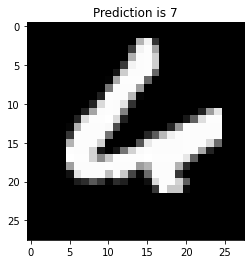

In [ ]:
# and show an example
x, y = next(iter(val_loader))
x = x.numpy().T
y = y.numpy().T
plt.title(f'Prediction is {np.argmax(forward(layers, x))}')
plt.imshow(x.reshape(28,28), cmap='gray');